In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression as MarkovAR
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.linear_model import LinearRegression as sklr
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sys
!{sys.executable} -m pip install arch

In [ ]:
import scipy
def ecdf(t,y):
    n = len(y)
    res = 0
    for val in y:
        if val<=t:
            res+=1/n
    return res

In [ ]:
data = pd.read_excel('21.07.2022 data_quarterly.xlsx',header=1)
data = data.rename(columns={'Unnamed: 0':'date'}).drop(columns=['Unnamed: 1'])
data['date'] = pd.to_datetime(data.date,format='%Y:%M.%f')
data

$$z_t = GDP_t$$

$$y_t =100  \frac{z_t}{z_{t-4}}, \hspace{6pt} t = 4,5,\dots,n+4$$

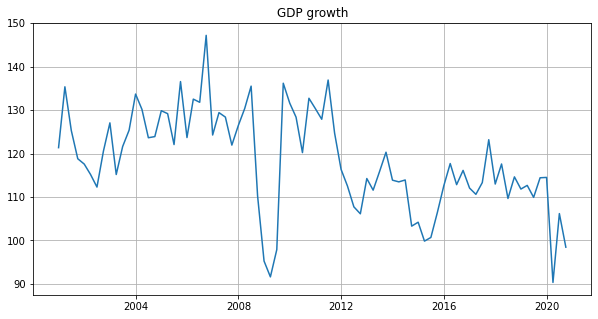

In [ ]:
data_new = data[['date','gdp_kz','ex','Inv_tot','rub_kzt_growth','cpi_kz','usd_rub','other_income_bop','defl','fao']].copy()
data_new['ex1'] = data_new.ex.shift(1)
data_new['gdp1'] = data_new.gdp_kz.shift(1)
data_new = data_new.dropna()

X = data_new[['ex1','Inv_tot','rub_kzt_growth','cpi_kz','usd_rub','other_income_bop','defl','fao']].copy()
y = data_new.gdp_kz
plt.figure(figsize=(10,5))
plt.plot(data_new.date,y)
plt.grid()
plt.title('GDP growth')
plt.show()

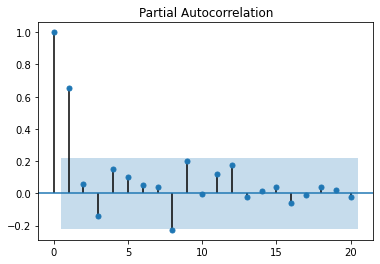

In [ ]:
pacf = sm.graphics.tsa.plot_pacf(y)

Linear model


$$y_t = \mu_t + w_1 x^1_t + w_2 x^2_t + \dots + w_k x^k_t + \varepsilon_t,\hspace{6pt} \varepsilon_t \sim N(0,\sigma^2_t)$$



Pairplots

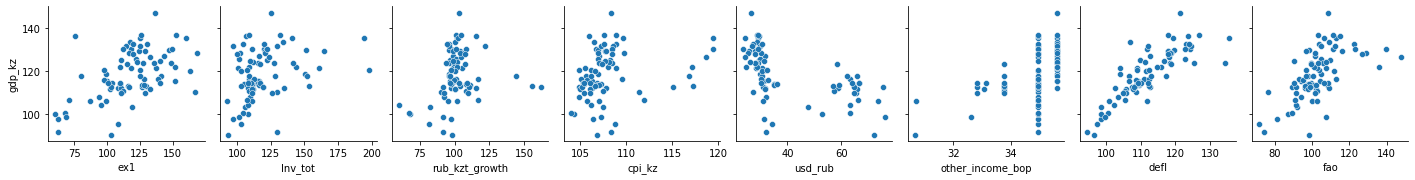

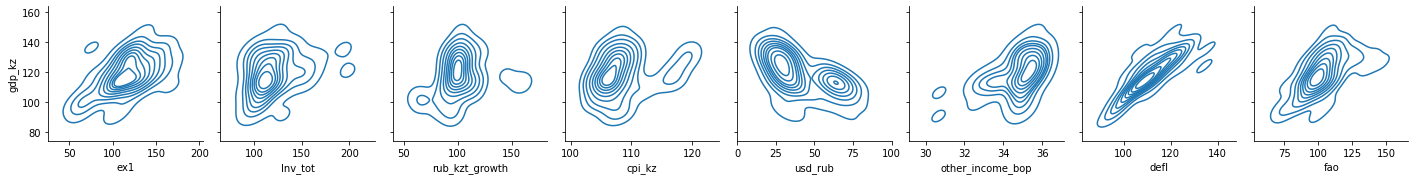

In [ ]:
sns.pairplot(data_new.drop(columns=['date']), y_vars=["gdp_kz"],
    x_vars=['ex1','Inv_tot','rub_kzt_growth','cpi_kz','usd_rub','other_income_bop','defl','fao'])
sns.pairplot(data_new.drop(columns=['date']), y_vars=["gdp_kz"],
    x_vars=['ex1','Inv_tot','rub_kzt_growth','cpi_kz','usd_rub','other_income_bop','defl','fao'],kind="kde")

Ordinary Least Squares

$$\widehat y_t = \widehat\mu_t + \widehat w_1 x^1_t + \widehat w_2 x^2_t + \dots + \widehat w_k x^k_t$$

$$\sum_t(y_t - \widehat\mu_t + \widehat w_1 x^1_t + \widehat w_2 x^2_t + \dots + \widehat w_k x^k_t)^2 → min$$

In [ ]:
model = sm.regression.linear_model.OLS(exog=X,endog=y)
model_fit = model.fit()
print(model_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                 gdp_kz   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              6687.
Date:                Sat, 27 Aug 2022   Prob (F-statistic):                   3.82e-100
Time:                        08:11:16   Log-Likelihood:                         -231.33
No. Observations:                  80   AIC:                                      478.7
Df Residuals:                      72   BIC:                                      497.7
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

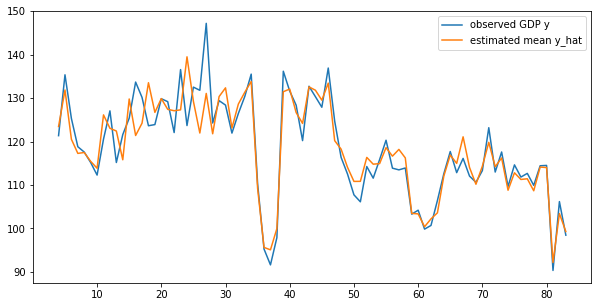

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y,label='observed GDP y')
plt.plot(model_fit.predict(exog=X),label='estimated mean y_hat')
plt.legend()
plt.show()

Lasso

$$\sum_t (y_t - \widehat y_t)^2 + \lambda \sum_{i=1}^k |w_i|$$

best alpha: 2.178787878787879


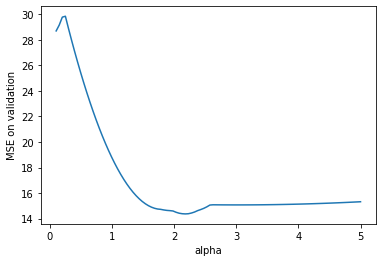

In [ ]:
n = len(y)
train_size=0.7
val_size = 0.2
y_val = y[int(n*(train_size-val_size)):int(n*train_size)]
X_val = X[int(n*(train_size-val_size)):int(n*train_size)].to_numpy()
mse_list = []
alpha_grid = np.linspace(0.1,5,num=100)

for alpha in alpha_grid:
    y_val_hat = []
    for i in range(len(y_val)):
        X_train = X[:int(n*train_size)-len(y_val)+i].to_numpy()
        y_train = y[:int(n*train_size)-len(y_val)+i]
        lasso_fit = Lasso(alpha=alpha).fit(X=X_train,y=y_train)
        y_val_hat.append(lasso_fit.predict([X_val[i]]))
    mse_list.append(MSE(y_val.values,y_val_hat))

best_alpha = alpha_grid[mse_list.index(min(mse_list))]
print('best alpha:',best_alpha)
plt.plot(alpha_grid,mse_list)
plt.xlabel('alpha')
plt.ylabel('MSE on validation')
plt.show()

RMSE on test 3.000459086415163


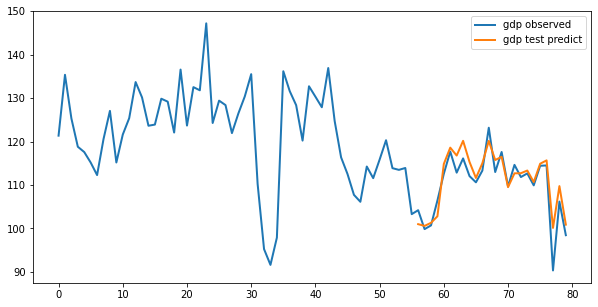

In [ ]:
y_test_hat = []
train_size=0.7
y_test = y[int(n*train_size):]
X_test = X[int(n*train_size):].to_numpy()


for i in range(len(y_test)):
    X_train = X[:-len(y_test)+i].to_numpy()
    y_train = y[:-len(y_test)+i]
    model_fit = Lasso(alpha=best_alpha).fit(X=X_train,y=y_train)
    y_test_hat.append(model_fit.predict([X_test[i]]))

plt.figure(figsize=(10,5))
plt.plot(y.values,label='gdp observed',linewidth=2)
plt.plot(range(int(n*train_size),n),y_test_hat,label='gdp test predict',linewidth=2)
plt.legend()
print('RMSE on test',MSE(y_test,y_test_hat,squared=False))

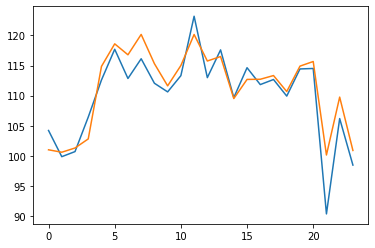

In [ ]:
plt.plot(y_test.values)
plt.plot(y_test_hat)

Residual analysis

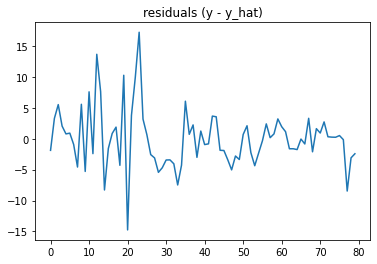

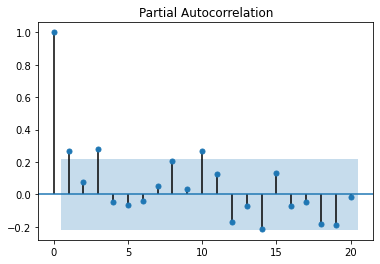

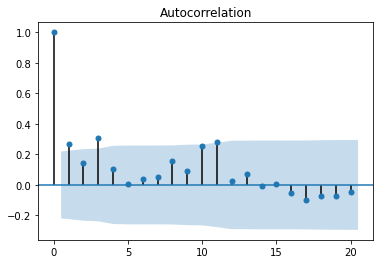

In [ ]:
resid = y.values - model_fit.predict(X.values)
plt.plot(resid)
plt.title('residuals (y - y_hat)')
plt.show()
resid_pacf=sm.graphics.tsa.plot_pacf(abs(resid**2 ))
resid_acf=sm.graphics.tsa.plot_acf(abs(resid**2))

GARCH(1,1)

$$\sigma^2_t = \alpha_1 \sigma^2_{t-1} + \beta_1 \varepsilon^2_{t-1}$$

In [ ]:
from arch import arch_model
sigma_fit = arch_model(resid,p=1,q=1, vol = "GARCH",mean='Zero').fit()

In [ ]:
sigma_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.012
Vol Model:                      GARCH   Log-Likelihood:               -225.367
Distribution:                  Normal   AIC:                           456.735
Method:            Maximum Likelihood   BIC:                           463.881
                                        No. Observations:                   80
Date:                Sat, Aug 27 2022   Df Residuals:                       80
Time:                        08:13:29   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          5.3907      2.683      2.010  4.448e-02   [  0.133, 10.648]
alpha[1]       0.6311      0.273      2.315  2.059e-02 [9.688e-02,  1.165]
beta[1]        0.2010      0.210      0.956      0.339   [ -0.211,  0.613]
==========================================================================

Covariance estimator: robust
"""

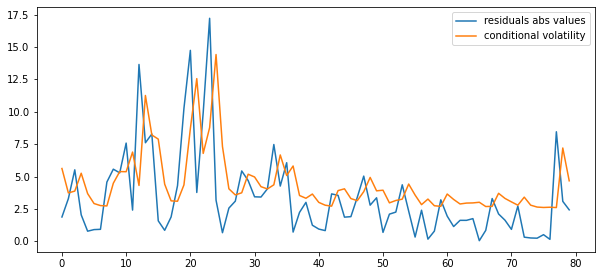

In [ ]:
plt.figure(figsize=(10,4.5))
plt.plot(abs(resid),label='residuals abs values')
plt.plot(sigma_fit.conditional_volatility[:],label='conditional volatility')
plt.legend()

In [ ]:
resid_test_hat = {}
train_size=0.8

resid_test = resid[int(n*train_size):]
X_test = X[int(n*train_size):].to_numpy()


for i in range(len(resid_test)):
    resid_train = resid[:-len(resid_test)+i]
    arch_mod = arch_model(resid_train,p=1,q=1, vol = "GARCH",mean='Zero')
    arch_fit = arch_mod.fit()
    resid_test_hat[arch_fit.forecast(reindex=False).variance.index[0]+1]=arch_fit.forecast(reindex=False).variance.values[0][0]
resid_test_hat = pd.Series(data=resid_test_hat)
resid_train = resid[:int(n*train_size)] 
arch_mod = arch_model(resid_train,p=1,q=1, vol = "GARCH",mean='Zero')
arch_fit = arch_mod.fit()

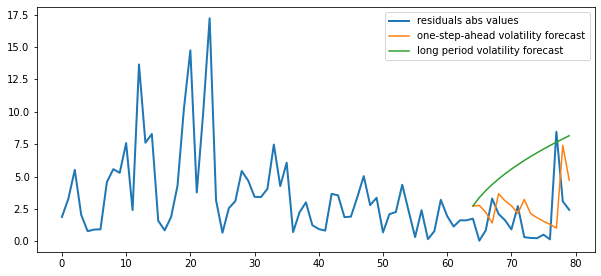

In [ ]:
plt.figure(figsize=(10,4.5))
plt.plot(abs(resid),label='residuals abs values',linewidth=2)
plt.plot(resid_test_hat**(1/2),label='one-step-ahead volatility forecast')
plt.plot(range(int(n*train_size),n),arch_fit.forecast(horizon=n-int(n*train_size),reindex=False).variance.values[0]**(1/2),label='long period volatility forecast')
plt.legend()
plt.show()

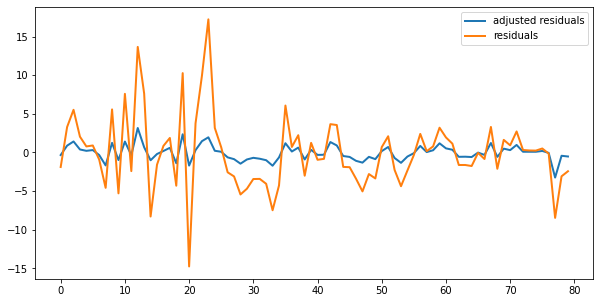

In [ ]:
vol = sigma_fit.conditional_volatility
plt.figure(figsize=(10,5))
plt.plot([resid[i]/vol[i] for i in range(80)],label='adjusted residuals',linewidth=2)
plt.plot(resid,label='residuals',linewidth=2)
plt.legend()

Kolmogorov-Smirnov test: KstestResult(statistic=0.08708748822612267, pvalue=0.5493846291821913)


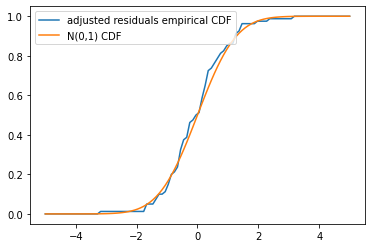

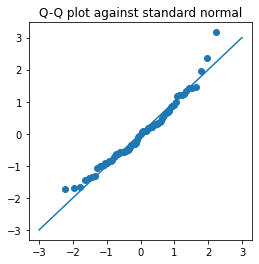

In [ ]:
resid_adj = np.array([resid[i]/vol[i] for i in range(80)])
#print('White test p-value for adj residuals and time independence',sm.stats.diagnostic.het_white(resid=resid_adj,exog=np.array([[i] for i in range(n)])))

t_list = np.linspace(-5,5,num=100)
resid_std = (resid-np.mean(resid))/np.std(resid)*(n/(n-1))**(1/2)
plt.plot(t_list,[ecdf(t,resid_adj) for t in t_list], label ='adjusted residuals empirical CDF')
plt.plot(t_list,scipy.stats.norm.cdf(t_list),label = 'N(0,1) CDF')
plt.legend()
print('Kolmogorov-Smirnov test:',stats.kstest(resid_adj,
             stats.norm.cdf))
plt.figure(figsize=(4,4))
plt.scatter(y=sorted(resid_adj),x=[stats.norm.ppf(i/n, loc=0, scale=1) for i in range(n)])
plt.plot([-3,3],[-3,3])
plt.title('Q-Q plot against standard normal')
plt.show()

GLS

In [ ]:
gls_model = sm.GLS(endog=y,exog=X,sigma = vol**2)
gls_fit = gls_model.fit()
print(gls_fit.summary())

                                 GLS Regression Results                                
Dep. Variable:                 gdp_kz   R-squared (uncentered):                   0.999
Model:                            GLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.355e+04
Date:                Sat, 27 Aug 2022   Prob (F-statistic):                   3.56e-111
Time:                        08:14:05   Log-Likelihood:                         -210.62
No. Observations:                  80   AIC:                                      437.2
Df Residuals:                      72   BIC:                                      456.3
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

Now we will try to predict real GDP

In [ ]:
data['gdp_real'] = data['gdp_kz']/data['defl']*100
data['hh1'] = data.hh.shift(1)
data['hh2'] = data.hh.shift(2)
data['hh4'] = data.hh.shift(4)
data['ex1'] = data.hh.shift(1)
data['ex2'] = data.hh.shift(2)
data['ex3'] = data.hh.shift(3)
data['ex4'] = data.hh.shift(4)
data['gdp_real1'] = data.gdp_real.shift(1)
data['total_budget_income_growth'] = 100*data['total_budget_income']/data['total_budget_income'].shift(4)

                            OLS Regression Results                            
Dep. Variable:               gdp_real   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     9.981
Date:                Sat, 27 Aug 2022   Prob (F-statistic):           1.20e-08
Time:                        08:17:53   Log-Likelihood:                -226.05
No. Observations:                  80   AIC:                             468.1
Df Residuals:                      72   BIC:                             487.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Inv_tot             

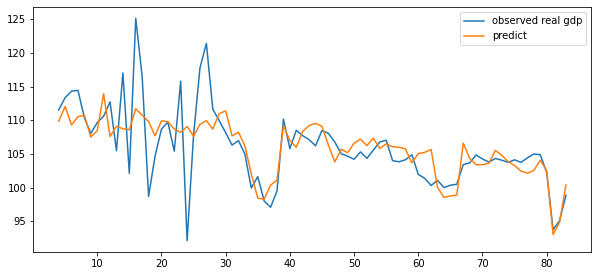

In [ ]:
X = data.copy()
X = X[['gdp_real','Inv_tot','cpi_kz','total_budget_income_growth','usd_kzt_growth','other_income_bop','fao','w_gdp_nomin']].dropna()
X['const']=1
y = X.gdp_real
X = X.drop(columns=['gdp_real'])

real_model = sm.OLS(exog=X,endog=y).fit()
y_hat = real_model.predict(exog=X)
print(real_model.summary())
plt.figure(figsize=(10,4.5))
plt.plot(y,label='observed real gdp')
plt.plot(y_hat,label='predict')
plt.legend()
print('RMSE',MSE(y,y_hat,squared=False))
print('MAE',MAE(y,y_hat))
X = X.drop(columns=['const'])

Due to big outliers in the 10-30 observations we should use more robust methods.

First we'll use SGDRegressor for ElasticNet regularized L1-regression implemetation. The hyper parameters are chosen with GridSearchCV on the training(validation) set

In [ ]:
from sklearn.linear_model import SGDRegressor
n = len(y)
test_size = 0.25

y_val = y[:int(n*(1-test_size))].values
X_val = X[:int(n*(1-test_size))].values

sc_x = StandardScaler()
sc_y = StandardScaler()
X_val_sc = sc_x.fit_transform(X_val)
y_val_sc = sc_y.fit_transform(y_val.reshape(-1,1))

params_dict = {'eta0':np.exp(np.linspace(-8,0,num=30)),'alpha':np.linspace(0.001,4,num=100),'l1_ratio':np.linspace(0,1,num=20)}
model = SGDRegressor(loss='epsilon_insensitive',epsilon=0,learning_rate='adaptive',penalty='elasticnet')
model_tuner = GridSearchCV(estimator=model,param_grid=params_dict,cv=10)
model_tuner.fit(y=y_val_sc.ravel(),X=X_val_sc)

GridSearchCV(cv=10,
             estimator=SGDRegressor(epsilon=0, learning_rate='adaptive',
                                    loss='epsilon_insensitive',
                                    penalty='elasticnet'),
             param_grid={'alpha': array([1.00000000e-03, 4.13939394e-02, 8.17878788e-02, 1.22181818e-01,
       1.62575758e-01, 2.02969697e-01, 2.43363636e-01, 2.83757576e-01,
       3.24151515e-01, 3.64545455e-01, 4.04939394e-01, 4.45333333e-01,
       4.85727273e-01, 5....
       8.35125281e-02, 1.10041628e-01, 1.44998123e-01, 1.91059112e-01,
       2.51752115e-01, 3.31725229e-01, 4.37103090e-01, 5.75955926e-01,
       7.58917602e-01, 1.00000000e+00]),
                         'l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])})

In [ ]:
print(model_tuner.best_params_)

{'alpha': 0.40493939393939393, 'eta0': 0.43710309040247686, 'l1_ratio': 0.05263157894736842}


MAE 1.653994300439193
RMSE 1.9409441167104604


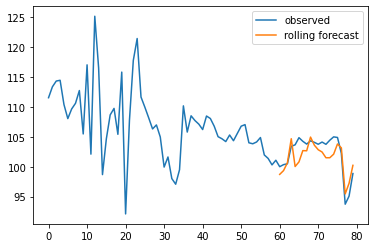

In [ ]:
best_params = model_tuner.best_params_
n = len(y)
#X = X.drop(columns=['total_budget_income_growth'])
y_test = y[int(n*(1-test_size)):]
X_test = X[int(n*(1-test_size)):].to_numpy()
y_test_hat = []
for i in range(len(y_test)):
    X_train = X[:-len(y_test)+i].to_numpy()
    y_train = y[:-len(y_test)+i]
    sc_x = StandardScaler().fit(X_train)
    sc_y = StandardScaler().fit(y_train.values.reshape(-1,1))
    np.random.seed(0)
    sgd_model = SGDRegressor(loss='epsilon_insensitive',epsilon=0,alpha=best_params['alpha'],
                             learning_rate='adaptive',eta0 = best_params['eta0'],l1_ratio=best_params['l1_ratio'],penalty='elasticnet')
    sgd_fit = sgd_model.fit(X=sc_x.transform(X_train),y=sc_y.transform(y_train.values.reshape(-1,1)).ravel())
    y_test_hat.append(sgd_fit.predict(sc_x.transform([X_test[i]])))


print('MAE',MAE(y_test,sc_y.inverse_transform(y_test_hat)))
print('RMSE',MSE(y_test,sc_y.inverse_transform(y_test_hat),squared=False))
plt.plot(y.values,label='observed')
plt.plot(range(int(n*(1-test_size)),n),sc_y.inverse_transform(y_test_hat),label='rolling forecast')
plt.legend()
plt.show()

Next method is Huber regression which employs a different loss function: squared loss for small errors and linear loss for big ones

In [ ]:
from sklearn.linear_model import HuberRegressor

y_val = y[:int(n*(1-test_size))].values
X_val = X[:int(n*(1-test_size))].values

sc_x = StandardScaler()
sc_y = StandardScaler()
X_val_sc = sc_x.fit_transform(X_val)
y_val_sc = sc_y.fit_transform(y_val.reshape(-1,1))

param_grid = {'alpha':np.linspace(0,3,num=100),'epsilon':np.linspace(1,3,num=100)}
model1 = HuberRegressor()
model1_tuner = GridSearchCV(estimator=model1,param_grid=param_grid)
model1_tuner.fit(X=X_val_sc,y=y_val_sc.ravel())
print(model1_tuner.best_params_)

MAE 2.0052405460851155
RMSE 2.4671567006936432


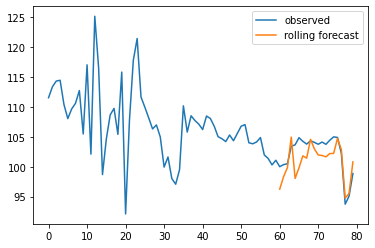

In [ ]:
X_test = X[int(n*(1-test_size)):].to_numpy()
y_test_hat = []
for i in range(len(y_test)):
    X_train = X[:-len(y_test)+i].to_numpy()
    y_train = y[:-len(y_test)+i]
    np.random.seed(0)
    sc_x = StandardScaler().fit(X_train)
    sc_y = StandardScaler().fit(y_train.values.reshape(-1,1))
    model1_fit = model1.fit(X=sc_x.transform(X_train),y=sc_y.transform(y_train.values.reshape(-1,1)).ravel())
    y_test_hat.append(model1_fit.predict(sc_x.transform([X_test[i]])))


print('MAE',MAE(y_test,sc_y.inverse_transform(y_test_hat)))
print('RMSE',MSE(y_test,sc_y.inverse_transform(y_test_hat),squared=False))
plt.plot(y.values,label='observed')
plt.plot(range(int(n*(1-test_size)),n),sc_y.inverse_transform(y_test_hat),label='rolling forecast')
plt.legend()
plt.show()